# Predicting Term Sheet Purchase

#### Model Buidling Steps

- 
- 
- 
- 
- 
- 
- 

#### References

- https://stackoverflow.com/questions/46062679/right-order-of-doing-feature-selection-pca-and-normalization

- https://towardsdatascience.com/preventing-data-leakage-in-your-machine-learning-model-9ae54b3cd1fb

> Import analysis and visualization libraires

In [76]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype

> Import dataset

- drop duration column (directly impacts the target varible and not good for modelling)

In [77]:
path= '../../datasets/main_data/bank-additional-full.csv'
full_bank = pd.read_csv(path, sep=';')

In [78]:
full_bank.shape

(41188, 21)

In [79]:
full_bank.drop('duration', axis=1, inplace=True)

In [80]:
full_bank.shape

(41188, 20)

> import project-defined modules

In [81]:
from plot import plot_univariate, plot_bivariate
from data import check_outliers, treat_outliers

> Import preprocessing libraries

In [82]:
from sklearn.preprocessing import StandardScaler,RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from imblearn.over_sampling import SMOTE, _random_over_sampler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, from_model, SelectKBest,chi2, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest # outlier detection and re,oval
from collections import Counter

> Import estimator libraries

In [83]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

> Import libraries for measuring model perofrmance

In [84]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

> Import production libraries

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import joblib

#### Data Preprocessing

In [86]:
full_bank

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [87]:
full_bank.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [88]:
full_bank.isna().any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

#### Outlier Detection and Treatment

> check for outliers

In [89]:
check_outliers(full_bank)

,age,campaign,pdays,previous,cons.conf.idx
0,56,1,999,0,-36.4
1,57,1,999,0,-36.4
2,37,1,999,0,-36.4
3,40,1,999,0,-36.4
4,56,1,999,0,-36.4
...,...,...,...,...,...
41183,73,1,999,0,-50.8
41184,46,1,999,0,-50.8
41185,56,2,999,0,-50.8
41186,44,1,999,0,-50.8


> treat outliers

In [90]:
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(full_bank.select_dtypes(exclude='object'))
# select all rows that are not outliers
mask = yhat != -1 
clean_df1 = full_bank[mask]
# summarize the shape of the updated training dataset
print(clean_df1.shape)

(37069, 20)


In [91]:
clean_df1

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40541,30,admin.,single,university.degree,no,yes,no,cellular,aug,tue,1,999,0,nonexistent,-1.7,94.027,-38.3,0.886,4991.6,no
40542,30,admin.,single,university.degree,no,no,no,cellular,aug,tue,1,999,0,nonexistent,-1.7,94.027,-38.3,0.886,4991.6,yes
40545,31,admin.,single,high.school,no,no,no,cellular,aug,tue,1,999,1,failure,-1.7,94.027,-38.3,0.886,4991.6,no
40550,34,blue-collar,married,basic.9y,no,yes,no,cellular,aug,tue,2,999,0,nonexistent,-1.7,94.027,-38.3,0.886,4991.6,no


#### Now let's check for class imbalance

Text(0.7, 30000, "Class Imbalance Count:\n\n{'no': 34235, 'yes': 2834}")

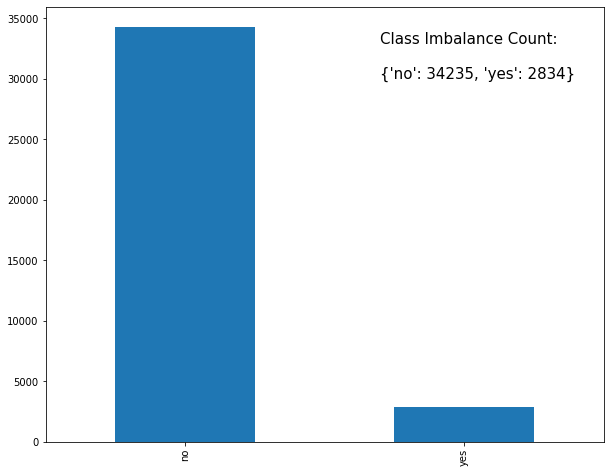

In [92]:
plt.subplots(figsize=(10,8))
clean_df1['y'].value_counts().plot(kind='bar')
plt.text(x=0.7, y=30000, s=f'Class Imbalance Count:\n\n{clean_df1.y.value_counts().to_dict()}', fontsize=15)

> We have a very high class imbalance

> This would be dealt with after splitting out data to train and test and applied only to train to avoid data leakage

#### split data

> Beofore further preprocessing, it is important we split the data into train and test set to avoid `data leakage`

In [93]:
features, target = clean_df1.drop('y', axis=1), pd.DataFrame(clean_df1['y'])

#### encode categorical variables

In [94]:
def encode (data):
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore', )
    to_encode = data.select_dtypes(exclude='number')
    if data.shape[1] > 1:
        #ohe = MultiLabelBinarizer()
        data.drop(to_encode.columns.tolist(), axis=1, inplace = True)
        features_cat_encode = pd.DataFrame(ohe.fit_transform(to_encode))
        data = data.merge(features_cat_encode, left_index=True, right_index=True)
        #print(ohe.classes_) 
    else:
        data = pd.DataFrame(ohe.fit_transform(to_encode))
        print(ohe.categories_) 
    return data 

In [95]:
features = encode(features)
features

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,42,43,44,45,46,47,48,49,50,51
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37062,43,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
37063,42,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
37064,42,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
37065,32,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [96]:
target = encode(target)

[array(['no', 'yes'], dtype=object)]


In [97]:
target

,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
37064,1.0,0.0
37065,0.0,1.0
37066,1.0,0.0
37067,1.0,0.0


> make shape equal

In [98]:
target=target.iloc[0:features.shape[0]]

In [99]:
target

,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
36382,1.0,0.0
36383,1.0,0.0
36384,1.0,0.0
36385,1.0,0.0


> trim target varibles `purchase` to a single column of `yes`

In [100]:
target.drop(0, axis=1, inplace=True)

/home/patrick/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [101]:
target

,1
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
36382,0.0
36383,0.0
36384,0.0
36385,0.0


In [102]:
X_train, x_test, Y_train, y_test = train_test_split(features, target,
                                               test_size=.10, random_state=1234)

In [103]:
X_train

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,42,43,44,45,46,47,48,49,50,51
17241,47,3,999,0,1.4,93.918,-42.7,4.962,5228.1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
13135,29,1,999,0,1.4,93.918,-42.7,4.962,5228.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
24156,41,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
16136,32,1,999,0,1.4,93.918,-42.7,4.961,5228.1,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
11981,30,2,999,0,1.4,94.465,-41.8,4.958,5228.1,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32874,28,2,999,1,-1.8,92.893,-46.2,1.299,5099.1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
17185,56,1,999,0,1.4,93.918,-42.7,4.962,5228.1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
24124,42,1,999,1,-0.1,93.200,-42.0,4.191,5195.8,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
34580,28,1,999,1,-1.8,92.893,-46.2,1.266,5099.1,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [104]:
Y_train

,1
17104,0.0
13006,0.0
23956,0.0
16001,0.0
11855,0.0
...,...
32399,0.0
17048,0.0
23924,0.0
34086,0.0


#### Deal with class imbalance

In [105]:
Y_train[1].value_counts()

0.0    30399
1.0     2349
Name: 1, dtype: int64

> Since we have an imbalance case of very high majority vs very low minority,

> a good decision would be to use the SMOTE technique of oversampling the minority to mathc the majority class

In [106]:
oversample = SMOTE(random_state=27)
X_train, Y_train = oversample.fit_sample(X_train, Y_train)

In [107]:
X_train

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,42,43,44,45,46,47,48,49,50,51
0,47,3,999,0,1.4,93.918,-42.7,4.962000,5228.1,0.0,...,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0
1,29,1,999,0,1.4,93.918,-42.7,4.962000,5228.1,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,0.0
2,41,1,999,0,-0.1,93.200,-42.0,4.191000,5195.8,0.0,...,1.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0
3,32,1,999,0,1.4,93.918,-42.7,4.961000,5228.1,1.0,...,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.0
4,30,2,999,0,1.4,94.465,-41.8,4.958000,5228.1,1.0,...,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60793,31,1,999,0,1.1,93.994,-36.4,4.856414,5191.0,0.0,...,0.0,0.0,0.138135,0.000000,0.0,0.861865,0.000000,0.000000,1.000000,0.0
60794,31,2,999,0,-2.9,92.963,-40.8,1.260000,5076.2,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.786028,0.213972,0.213972,0.786028,0.0
60795,39,1,999,0,-0.1,93.200,-42.0,4.112824,5195.8,0.0,...,1.0,0.0,0.590070,0.409930,0.0,0.000000,0.000000,0.000000,1.000000,0.0
60796,45,1,999,0,1.4,93.444,-36.1,4.965000,5228.1,0.0,...,0.0,0.0,0.000000,0.648823,0.0,0.351177,0.000000,0.000000,1.000000,0.0


In [108]:
Y_train

,1
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
60793,1.0
60794,1.0
60795,1.0
60796,1.0


> compare the class distribution

In [109]:
trains = pd.merge(X_train, Y_train, left_index=True, right_index=True)

In [110]:
trains

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,43,44,45,46,47,48,49,50,51,1_y
0,47,3,999,0,1.4,93.918,-42.7,4.962000,5228.1,0.0,...,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0
1,29,1,999,0,1.4,93.918,-42.7,4.962000,5228.1,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,0.0,0.0
2,41,1,999,0,-0.1,93.200,-42.0,4.191000,5195.8,0.0,...,0.0,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0
3,32,1,999,0,1.4,93.918,-42.7,4.961000,5228.1,1.0,...,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.0,0.0
4,30,2,999,0,1.4,94.465,-41.8,4.958000,5228.1,1.0,...,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60793,31,1,999,0,1.1,93.994,-36.4,4.856414,5191.0,0.0,...,0.0,0.138135,0.000000,0.0,0.861865,0.000000,0.000000,1.000000,0.0,1.0
60794,31,2,999,0,-2.9,92.963,-40.8,1.260000,5076.2,0.0,...,0.0,0.000000,0.000000,0.0,0.786028,0.213972,0.213972,0.786028,0.0,1.0
60795,39,1,999,0,-0.1,93.200,-42.0,4.112824,5195.8,0.0,...,0.0,0.590070,0.409930,0.0,0.000000,0.000000,0.000000,1.000000,0.0,1.0
60796,45,1,999,0,1.4,93.444,-36.1,4.965000,5228.1,0.0,...,0.0,0.000000,0.648823,0.0,0.351177,0.000000,0.000000,1.000000,0.0,1.0


In [111]:
trains_class = trains['1_y'].value_counts().to_dict()
trains_class

{1.0: 30399, 0.0: 30399}

Text(0.2, 30000, 'Class Imbalance Count:\n\n{1.0: 30399, 0.0: 30399}')

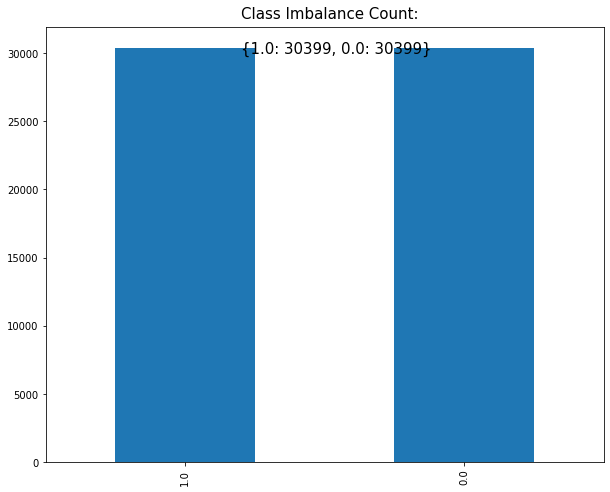

In [112]:
plt.subplots(figsize=(10,8))
trains['1_y'].value_counts().plot(kind='bar')
plt.text(x=0.2, y=30000, s=f'Class Imbalance Count:\n\n{trains_class}', fontsize=15)

> We now have a balanced class and can go on to further preprocess

#### Standardize train datasets

In [113]:
scaler = StandardScaler()
scaler

StandardScaler()

In [114]:
X_train = scaler.fit_transform(X_train)

In [115]:
X_train

array([[ 0.79777195,  0.36355009,  0.06874796, ..., -0.35166648,
         0.35456769, -0.04252373],
       [-1.01540697, -0.59553688,  0.06874796, ..., -0.35166648,
         0.35456769, -0.04252373],
       [ 0.19337898, -0.59553688,  0.06874796, ...,  3.13984049,
        -3.11278934, -0.04252373],
       ...,
       [-0.00808535, -0.59553688,  0.06874796, ..., -0.35166648,
         0.35456769, -0.04252373],
       [ 0.59630763, -0.59553688,  0.06874796, ..., -0.35166648,
         0.35456769, -0.04252373],
       [-1.31760345, -0.11599339,  0.06874796, ..., -0.35166648,
         0.35456769, -0.04252373]])

In [116]:
Y_train = scaler.fit_transform(Y_train)

In [117]:
Y_train

array([[-1.],
       [-1.],
       [-1.],
       ...,
       [ 1.],
       [ 1.],
       [ 1.]])

In [118]:
pd.DataFrame(Y_train)[0].value_counts()

 1.0    30399
-1.0    30399
Name: 0, dtype: int64

#### Dimensionality Reduction

> RIght now, our input variables are quite large, which has potential of affecting our prediciton

> To optimise the predictive features of our variables and save memory space on the model,

> we can reduce the number of features using PCA

In [74]:
pca = PCA()

#### Perform feature selection on numerical features

> At first I will plot the feature importacne for all featurs then decide on the number to use depending on the number of features

In [167]:
features_num = features.select_dtypes(include='number')
features_num.shape

(37069, 9)

In [179]:
scaler = StandardScaler()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...
40793,31,1,999,0,-1.1,94.199,-37.5,0.878,4963.6
40812,32,1,999,0,-1.1,94.199,-37.5,0.878,4963.6
40823,33,1,999,0,-1.1,94.199,-37.5,0.879,4963.6
40838,32,1,999,0,-1.1,94.199,-37.5,0.879,4963.6


In [168]:
# define feature selection, 
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(features_num, target)

/home/patrick/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SelectKBest(k='all')

> PLot Feature Importance

Feature 0: 29.371084
Feature 1: 76.221529
Feature 2: 10.009152
Feature 3: 0.139565
Feature 4: 1312.651487
Feature 5: 583.512400
Feature 6: 155.743507
Feature 7: 1228.455657
Feature 8: 1397.298094


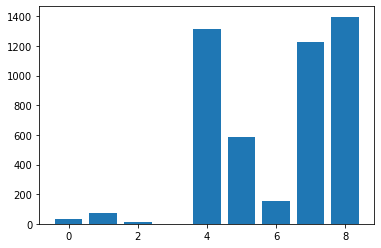

In [169]:
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [170]:
num_kbest = pd.DataFrame(fs.scores_, columns=['scores']).sort_values(
    ascending=False, by='scores').reset_index().rename(columns={'index':'features'})
num_kbest

,features,scores
0,8,1397.298094
1,4,1312.651487
2,7,1228.455657
3,5,583.512400
4,6,155.743507
5,1,76.221529
6,0,29.371084
7,2,10.009152
8,3,0.139565


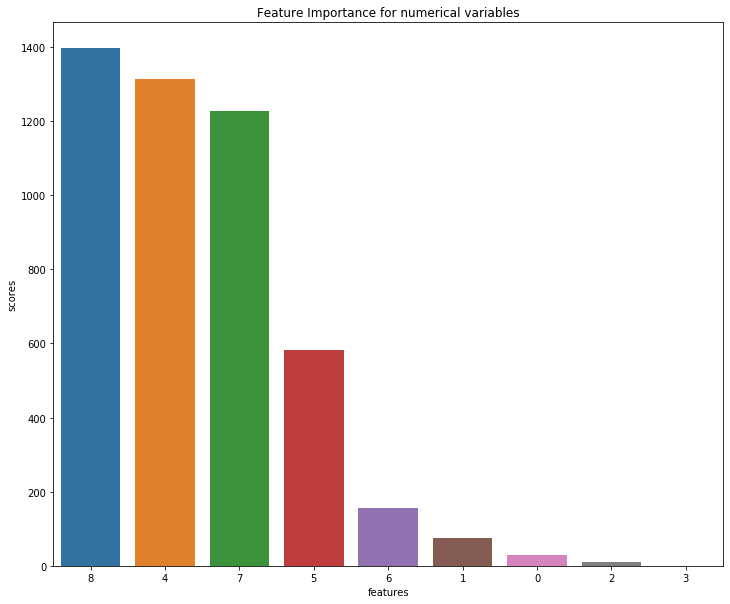

In [171]:
plt.subplots(figsize=(12,10))
sns.barplot(data=num_kbest, x='features', y='scores', order=num_kbest.features)
plt.title('Feature Importance for numerical variables')
plt.show()

> I would go with features that equals or above the average score

In [172]:
num_kbest_avg = num_kbest.scores.mean()
num_kbest_avg

532.6002751214006

In [173]:
num_kbest=num_kbest.query('scores >= @num_kbest_avg')
num_kbest

,features,scores
0,8,1397.298094
1,4,1312.651487
2,7,1228.455657
3,5,583.512400


> We have only 4 of such features

> about four features are most useful for our prediction, hence I will go for 4

In [175]:
# define feature selection, 
fs = SelectKBest(score_func=f_classif, k=4)
# apply feature selection
num_selected_kbest = fs.fit_transform(features_num, target)
print(num_selected_kbest.shape)

(37069, 4)


/home/patrick/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [176]:
num_selected_kbest

array([[ 1.1000e+00,  9.3994e+01,  4.8570e+00,  5.1910e+03],
       [ 1.1000e+00,  9.3994e+01,  4.8570e+00,  5.1910e+03],
       [ 1.1000e+00,  9.3994e+01,  4.8570e+00,  5.1910e+03],
       ...,
       [-1.1000e+00,  9.4199e+01,  8.7900e-01,  4.9636e+03],
       [-1.1000e+00,  9.4199e+01,  8.7900e-01,  4.9636e+03],
       [-1.1000e+00,  9.4199e+01,  8.8000e-01,  4.9636e+03]])

> 

#### Perform feature selection on categorical features

> I would take the same approach as the numerical vars on the cat vars

> But first, we have to encode our categorical variables using OneHotEncoding

In [130]:
fs_1 = SelectKBest(score_func=chi2, k='all')
fs_1.fit(features_cat_encode, target)

SelectKBest(k='all', score_func=<function chi2 at 0x7f4b7172cd08>)

In [144]:
for i in range(len(fs_1.scores_)):
	print('Feature %d: %f' % (i, fs_1.scores_[i]))

Feature 0: 19.192975
Feature 1: 34.827808
Feature 2: 0.018024
Feature 3: 7.261408
Feature 4: 0.083253
Feature 5: 18.868787
Feature 6: 1.304342
Feature 7: 8.612814
Feature 8: 123.288332
Feature 9: 0.659547
Feature 10: 0.955333
Feature 11: 0.378734
Feature 12: 4.252584
Feature 13: 18.278362
Feature 14: 58.276237
Feature 15: 0.718807
Feature 16: 21.536106
Feature 17: 5.026870
Feature 18: 12.689765
Feature 19: 0.075758
Feature 20: 0.673479
Feature 21: 1.251001
Feature 22: 53.961137
Feature 23: 0.017317
Feature 24: 32.217282
Feature 25: 110.170986
Feature 26: 0.249861
Feature 27: 0.781847
Feature 28: 2.640205
Feature 29: 1.381006
Feature 30: 0.185618
Feature 31: 2.640205
Feature 32: 0.124968
Feature 33: 137.652102
Feature 34: 216.844617
Feature 35: 316.272892
Feature 36: 5.248167
Feature 37: 85.660468
Feature 38: 5.860430
Feature 39: 4.459332
Feature 40: 701.230763
Feature 41: 86.622513
Feature 42: 22.644214
Feature 43: 285.549469
Feature 44: 67.422005
Feature 45: 0.937036
Feature 46: 3.076

In [152]:
cat_kbest = pd.DataFrame(fs_1.scores_, columns=['scores']).sort_values(
    ascending=False, by='scores').reset_index().rename(columns={'index':'features'})
cat_kbest.head(10)

,features,scores
0,40,701.230763
1,35,316.272892
2,43,285.549469
3,34,216.844617
4,33,137.652102
5,8,123.288332
6,25,110.170986
7,41,86.622513
8,37,85.660468
9,44,67.422005


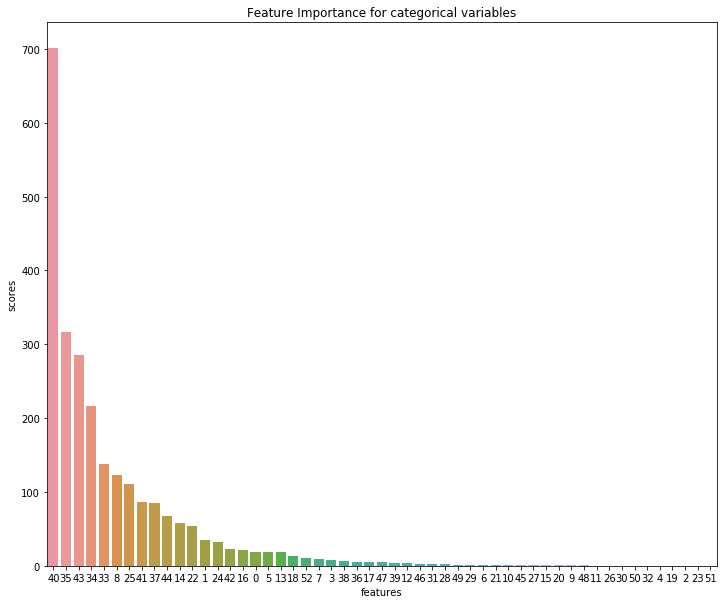

In [158]:
plt.subplots(figsize=(12,10))
sns.barplot(data=cat_kbest, x='features', y='scores', order=cat_kbest.features)
plt.title('Feature Importance for categorical variables')
plt.show()

> I would go with features that equals or above the average score

In [160]:
cat_kbest_avg = cat_kbest.scores.mean()
cat_kbest_avg

47.15224161403169

In [164]:
cat_kbest=cat_kbest.query('scores >= @cat_kbest_avg')
cat_kbest

,features,scores
0,40,701.230763
1,35,316.272892
2,43,285.549469
3,34,216.844617
4,33,137.652102
5,8,123.288332
6,25,110.170986
7,41,86.622513
8,37,85.660468
9,44,67.422005


> We have only 12 of such features

In [ ]:
> I would concatenate 

> encode categorical variables in features

> merge with train data

In [ ]:
for col in to